Describe the dataset:<br>
This dataset contains comprehensive flight details for various airlines. Each row represents a unique flight and contains 50+ features such as FlightDate, Airline, Origin, Destination, Cancelled status, Diverted status, Scheduled and Actual Departure and Arrival times, Departure and Arrival Delays, AirTime, Distance, Day of the week, Airline codes, Airport identifiers, Origin and Destination city names and states, and more.

Outline the types of insights you hope to gain from it and make hypotheses about what you might find:<br>
I aim to explore flight delays, cancellations, and diversions in detail. Here are some hypotheses that I could test:
Certain airlines might have more delays or cancellations than others.
Flight elapsed time diff might not be influenced by distance
Departure delays can be simulated as a training model.

In [35]:
# Flight Data Analysis
# This notebook presents an exploratory data analysis of a flight dataset. The goal is to identify trends and patterns related to flight delays and cancellations.

from pyspark.sql import SparkSession
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler

In [36]:
spark = SparkSession.builder \
    .appName("Read Parquet Files") \
    .master("yarn") \
    .getOrCreate()

In [37]:
parquet_files_path = "hdfs:/parquet_data/"
df = spark.read.parquet(parquet_files_path)
selected_df = df.select('FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted', 'DepDelayMinutes', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance')

In [38]:
selected_df.printSchema()

root
 |-- FlightDate: timestamp (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)



Collect and clean the data for analysis and provide a basic set of summary information about the features in your dataset: <br>
The Columns I left are:
| Column | Type | Unit |
|-----------------|-----------------|-----------------|
| FlightDate | timestamp | - |
| Airline | string | - |
| Origin | string | - |
| Dest | string | - |
| Cancelled | boolean | - |
| Diverted | boolean | - |
| DepDelayMinutes | double | min |
| CRSElapsedTime | double | min |
| ActualElapsedTime | double | min |
| Distance | double | mile |

In [39]:
print(selected_df.take(1))

[Row(FlightDate=datetime.datetime(2018, 1, 22, 16, 0), Airline='Endeavor Air Inc.', Origin='ABY', Dest='ATL', Cancelled=False, Diverted=False, DepDelayMinutes=0.0, CRSElapsedTime=62.0, ActualElapsedTime=59.0, Distance=145.0)]


In [40]:
# Which airline has the most cancelled flights?
cancelled = selected_df.filter(selected_df.Cancelled==True)

In [41]:
cancelled.createOrReplaceTempView("cancelled_table")
spark.sql("""
          SELECT airline, COUNT(*) as cancelled_count
          FROM cancelled_table
          GROUP BY airline
          ORDER BY cancelled_count DESC
          LIMIT 1
          """).show()
# Okay, Southwest Airline is the best known for its cancelled flights

23/05/20 01:01:56 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+---------------+
|             airline|cancelled_count|
+--------------------+---------------+
|Southwest Airline...|         171408|
+--------------------+---------------+



Design at least 3 “questions” (along the lines of those above) and answer them. Remember that presentation matters here.
- Question1: Which airlines have the most and least delays? 
- Question2: How distance influence difference between actual and expected elpased time?
- Question3: Estimating a new flight depart from LAX about how long it delays if it does.

Question1: Which airlines have the most and least delays?<br>
Because each airline has different total number of flights, comparing the ratio of delay is more accurate. 
The flight is not delayed when its value of DepDelayMinutes is equal to 0.
Result1:<br>
Southwest has the highest delayed ratio 0.45, 
Cape Air has the lowest, 0.15

In [42]:
selected_df.createOrReplaceTempView("flights")

In [43]:
total_flights_per_airline = spark.sql("""
                                        SELECT airline, COUNT(*) as totalFlights
                                        FROM flights
                                        GROUP BY airline
                                        """)
delayed_flights_per_airline = spark.sql("""
                                        SELECT airline, COUNT(*) as delayedFlights
                                        FROM flights
                                        WHERE DepDelayMinutes > 0
                                        GROUP BY airline
                                        """)

In [44]:
joined_table = total_flights_per_airline.join(delayed_flights_per_airline, "airline")

In [45]:
joined_table.createOrReplaceTempView("joined_table")
spark.sql("""
            SELECT *
            FROM (
                SELECT airline, totalFlights, delayedFlights, delayedFlights / totalFlights AS ratio
                FROM joined_table
            ) AS subquery
            ORDER BY ratio DESC
            LIMIT 1
            """).show()
spark.sql("""
            SELECT *
            FROM (
                SELECT airline, totalFlights, delayedFlights, delayedFlights / totalFlights AS ratio
                FROM joined_table
            ) AS subquery
            ORDER BY ratio ASC
            LIMIT 1
            """).show()

+--------------------+------------+--------------+-------------------+
|             airline|totalFlights|delayedFlights|              ratio|
+--------------------+------------+--------------+-------------------+
|Southwest Airline...|     5474339|       2444541|0.44654541854276836|
+--------------------+------------+--------------+-------------------+



+--------+------------+--------------+-------------------+
| airline|totalFlights|delayedFlights|              ratio|
+--------+------------+--------------+-------------------+
|Cape Air|        1661|           254|0.15291992775436483|
+--------+------------+--------------+-------------------+



Question2: How distance influence difference between actual and expected elpased time?<br>
The first time I use the difference between actual and expected elapsed time, and it seems that the difference doesn't change by distance, with the diff evenly among the range however distances are.
I drew a graph of actual elapsed time corresponding to distance, obviously a straight line. 

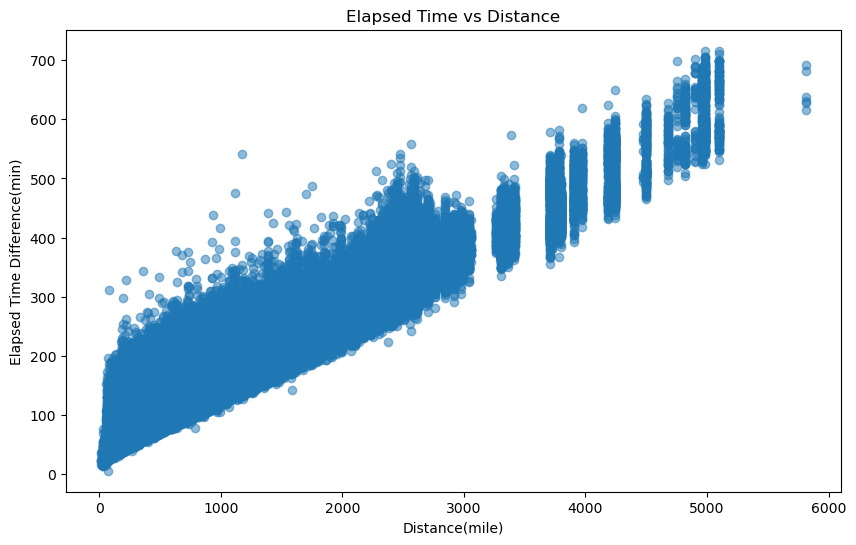

In [46]:
sampled_df = selected_df.sample(False, 0.1)
# sampled_df = sampled_df.withColumn("ElapsedTimeDiff", sampled_df["ActualElapsedTime"] - sampled_df["CRSElapsedTime"])
graph_df = sampled_df.select("Distance", "ActualElapsedTime").toPandas()
plt.figure(figsize=(10,6))
plt.scatter(graph_df["Distance"], graph_df["ActualElapsedTime"], alpha=0.5)
plt.title('Elapsed Time vs Distance')
plt.xlabel('Distance(mile)')
plt.ylabel('Elapsed Time Difference(min)')
plt.show()

Question3: Estimating a new flight how long it delays if it does.
Here I create a TensorFlow NN model to train 80% data and leave 20% testing data.<br>
The loss of model tested by remaining part is 1600, which means there is 40 minutes difference compared to the actual delayed time. Not a small number, but I only run 100 epoches and 5% of the whole dataframe due to the restriction of CPU. Training more data will cause Mean Squared Error decrease gradually if the machine can support it. 


In [24]:
ml_df = selected_df.dropna()
ml_df = ml_df.filter(ml_df.Origin == "LAX")
ml_df = ml_df.drop("Origin")

In [25]:
ml_df = ml_df.sample(False, 0.05)
indexer = StringIndexer(inputCols= ["Airline", "Dest"], outputCols=["AirlineIndex", "DestIndex"])
ml_df = indexer.fit(ml_df).transform(ml_df)

encoder = OneHotEncoder(inputCols= ["AirlineIndex", "DestIndex"], outputCols=["AirlineVec", "DestVec"])
ml_df = encoder.fit(ml_df).transform(ml_df)

In [27]:
assembler = VectorAssembler(
    inputCols=["AirlineVec", "DestVec", "CRSElapsedTime", "ActualElapsedTime", "Distance"],
    outputCol="features")
ml_df = assembler.transform(ml_df)


In [26]:
ml_df.count()

41552

In [28]:
train_data, test_data = ml_df.randomSplit([0.8, 0.2])
train_pd = train_data.toPandas()
test_pd = test_data.toPandas()

/bigdata/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/bigdata/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [29]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [30]:
class FlightDelayDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = torch.tensor(row['features'], dtype=torch.float)
        y = torch.tensor(row['DepDelayMinutes'], dtype=torch.float)
        return x, y

train_dataset = FlightDelayDataset(train_pd)
test_dataset = FlightDelayDataset(test_pd)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [32]:
model = Net(input_size=134)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / i))

/home2/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home2/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([49])) that is different to the input size (torch.Size([49, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 loss: 1644.637
Epoch 2 loss: 1624.813
Epoch 3 loss: 1623.349
Epoch 4 loss: 1622.183
Epoch 5 loss: 1621.024
Epoch 6 loss: 1621.479
Epoch 7 loss: 1620.311
Epoch 8 loss: 1620.020
Epoch 9 loss: 1619.674
Epoch 10 loss: 1619.124
Epoch 11 loss: 1620.065
Epoch 12 loss: 1620.234
Epoch 13 loss: 1619.291
Epoch 14 loss: 1619.671
Epoch 15 loss: 1618.715
Epoch 16 loss: 1619.217
Epoch 17 loss: 1619.239
Epoch 18 loss: 1618.503
Epoch 19 loss: 1619.659
Epoch 20 loss: 1620.064
Epoch 21 loss: 1618.428
Epoch 22 loss: 1618.853
Epoch 23 loss: 1618.647
Epoch 24 loss: 1617.620
Epoch 25 loss: 1618.854
Epoch 26 loss: 1617.810
Epoch 27 loss: 1618.472
Epoch 28 loss: 1617.886
Epoch 29 loss: 1618.050
Epoch 30 loss: 1617.741
Epoch 31 loss: 1618.723
Epoch 32 loss: 1617.952
Epoch 33 loss: 1617.457
Epoch 34 loss: 1618.096
Epoch 35 loss: 1619.892
Epoch 36 loss: 1620.026
Epoch 37 loss: 1617.669
Epoch 38 loss: 1617.433
Epoch 39 loss: 1617.343
Epoch 40 loss: 1617.802
Epoch 41 loss: 1617.492
Epoch 42 loss: 1617.176
E

In [34]:
# Now test the model
model.eval()
with torch.no_grad():
    total_loss = 0.0
    total_items = 0
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        total_items += inputs.size(0)
    print('Test Loss: %.3f' % (total_loss / total_items))

Test Loss: 1529.991
